## 계층적 군집(Hierarchical Clustering)

- 계층적 군집분석은 `데이터와 데이터`, `군집과 데이터`, `군집과 군집`간의 **거리**에 대한 유사도로 군집을 형성
- 두 점 사이를 가까운 것끼리 합치는 과정을 반복하여 전체가 하나의 클러스터에 속할 때까지 반복 수행함.
    - 이 과정에 대한 시각화 결과물이 덴드로그램 형태로 나타남
- 어떻게 두 점 사이의 거리를 결정할지에 대한 측정 방식이 필요함
    - 유클리디안 거리 측정(직선거리), 맨하탄 거리 측정 방식(블록거리)을 사용
- `sklearn`의 `AgglomerativeClustering` 클래스는 상향식 접근 방식을 사용하여 계층적 클러스터링 기능을 제공함.

> KMeans나 DBScan보다 군집 성능이 좋음

## #01. 준비작업

### [1] 패키지 가져오기

In [19]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from helper.util import *
from helper.plot import *
from helper.analysis import *

from sklearn.cluster import AgglomerativeClustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

In [20]:
origin = my_read_excel("https://data.hossam.kr/mldata/game_usage.xlsx", info=False)

## #02. 군집 수행

### [1] 원본 데이터 활용

#### (1) 군집 모델 구현

`n_clusters` 값을 통해 목표로 하는 군집수를 지정해 준다.

KMeans와 마찬가지로 Elbow Point를 활용할 수 도 있을 것이다.

In [21]:
estimator = AgglomerativeClustering(n_clusters=4)

estimator.fit(origin)

result_df = origin.copy()
result_df['cluster'] = estimator.labels_

my_pretty_table(result_df.head(10))

+----+--------------+--------------+-----------+
|    |   time spent |   game level |   cluster |
|----+--------------+--------------+-----------|
|  0 |           39 |          944 |         0 |
|  1 |           55 |          705 |         2 |
|  2 |           29 |          757 |         0 |
|  3 |           59 |          999 |         0 |
|  4 |            7 |          109 |         1 |
|  5 |           35 |          749 |         0 |
|  6 |           11 |          520 |         3 |
|  7 |           30 |          410 |         3 |
|  8 |           50 |          225 |         1 |
|  9 |           23 |          470 |         3 |
+----+--------------+--------------+-----------+


#### (2) 군집 결과 시각화

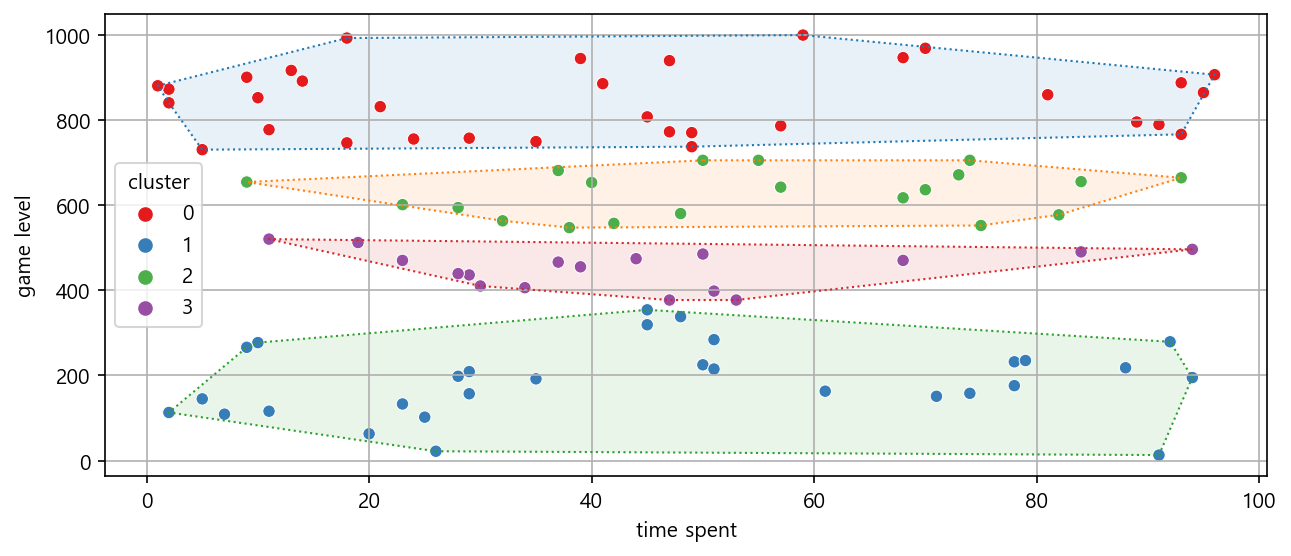

In [22]:
my_convex_hull(result_df, xname='time spent', yname='game level', hue='cluster', palette='Set1')

> 4개의 군집이 만들어지기는 했으나 단순히 레벨에 따른 군집으로 보인다.
>
> 데이터의 단위가 다르기 때문에 이런 현상이 발생한다.
>
> 스케일링을 수행하여 해결할 수 있다.

### [2] 스케일링 적용후 군집

#### (1) 스케일링

In [23]:
df = my_standard_scaler(origin)
my_pretty_table(df.head())

+----+--------------+--------------+
|    |   time spent |   game level |
|----+--------------+--------------|
|  0 |    -0.250733 |       1.4748 |
|  1 |     0.326494 |     0.606546 |
|  2 |      -0.6115 |     0.795456 |
|  3 |     0.470801 |      1.67461 |
|  4 |     -1.40519 |     -1.55865 |
+----+--------------+--------------+


#### (2) 군집 모델 구현

In [24]:
estimator = AgglomerativeClustering(n_clusters=4)

estimator.fit(df)

result_df = origin.copy()
result_df['cluster'] = estimator.labels_

my_pretty_table(result_df.head(10))

+----+--------------+--------------+-----------+
|    |   time spent |   game level |   cluster |
|----+--------------+--------------+-----------|
|  0 |           39 |          944 |         1 |
|  1 |           55 |          705 |         1 |
|  2 |           29 |          757 |         2 |
|  3 |           59 |          999 |         1 |
|  4 |            7 |          109 |         0 |
|  5 |           35 |          749 |         2 |
|  6 |           11 |          520 |         0 |
|  7 |           30 |          410 |         0 |
|  8 |           50 |          225 |         0 |
|  9 |           23 |          470 |         0 |
+----+--------------+--------------+-----------+


#### (3) 군집 결과 시각화

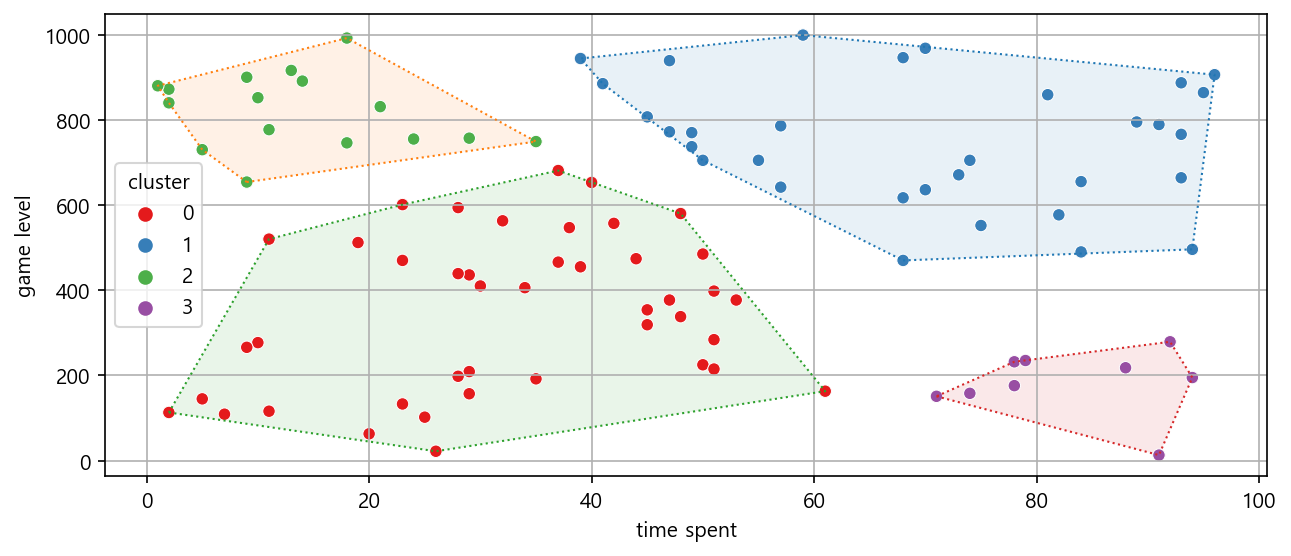

In [25]:
my_convex_hull(result_df, xname='time spent', yname='game level', hue='cluster', palette='Set1')

> 원하는 형태의 군집이 완성되었다.

### [3] 최종 모형에 대한 실루엣 지수 확인

In [26]:
def visualize_silhouette(estimator, X_features): 
    if hasattr(estimator, "n_clusters"):
        n_clusters = estimator.n_clusters
    else:
        labels = list(set(estimator.labels_))
        if -1 in labels:labels.remove(-1)
        n_clusters = len(labels)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    sil_avg = silhouette_score(X=X_features, labels=estimator.labels_)
    sil_values = silhouette_samples(X=X_features, labels=estimator.labels_)

    y_lower = 10
    plt.suptitle('Number of Cluster : '+ str(n_clusters)+', ' \
                        'Silhouette Score :' + str(round(sil_avg,3)) )
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_features) + (n_clusters + 1) * 10])
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.grid()

    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
    for i in range(n_clusters):
        ith_cluster_sil_values = sil_values[estimator.labels_==i]
        ith_cluster_sil_values.sort()

        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                            facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=sil_avg, color="red", linestyle="--")


      # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_features[X_features.columns[0]], X_features[X_features.columns[1]], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.grid()

    plt.show()
    plt.close()

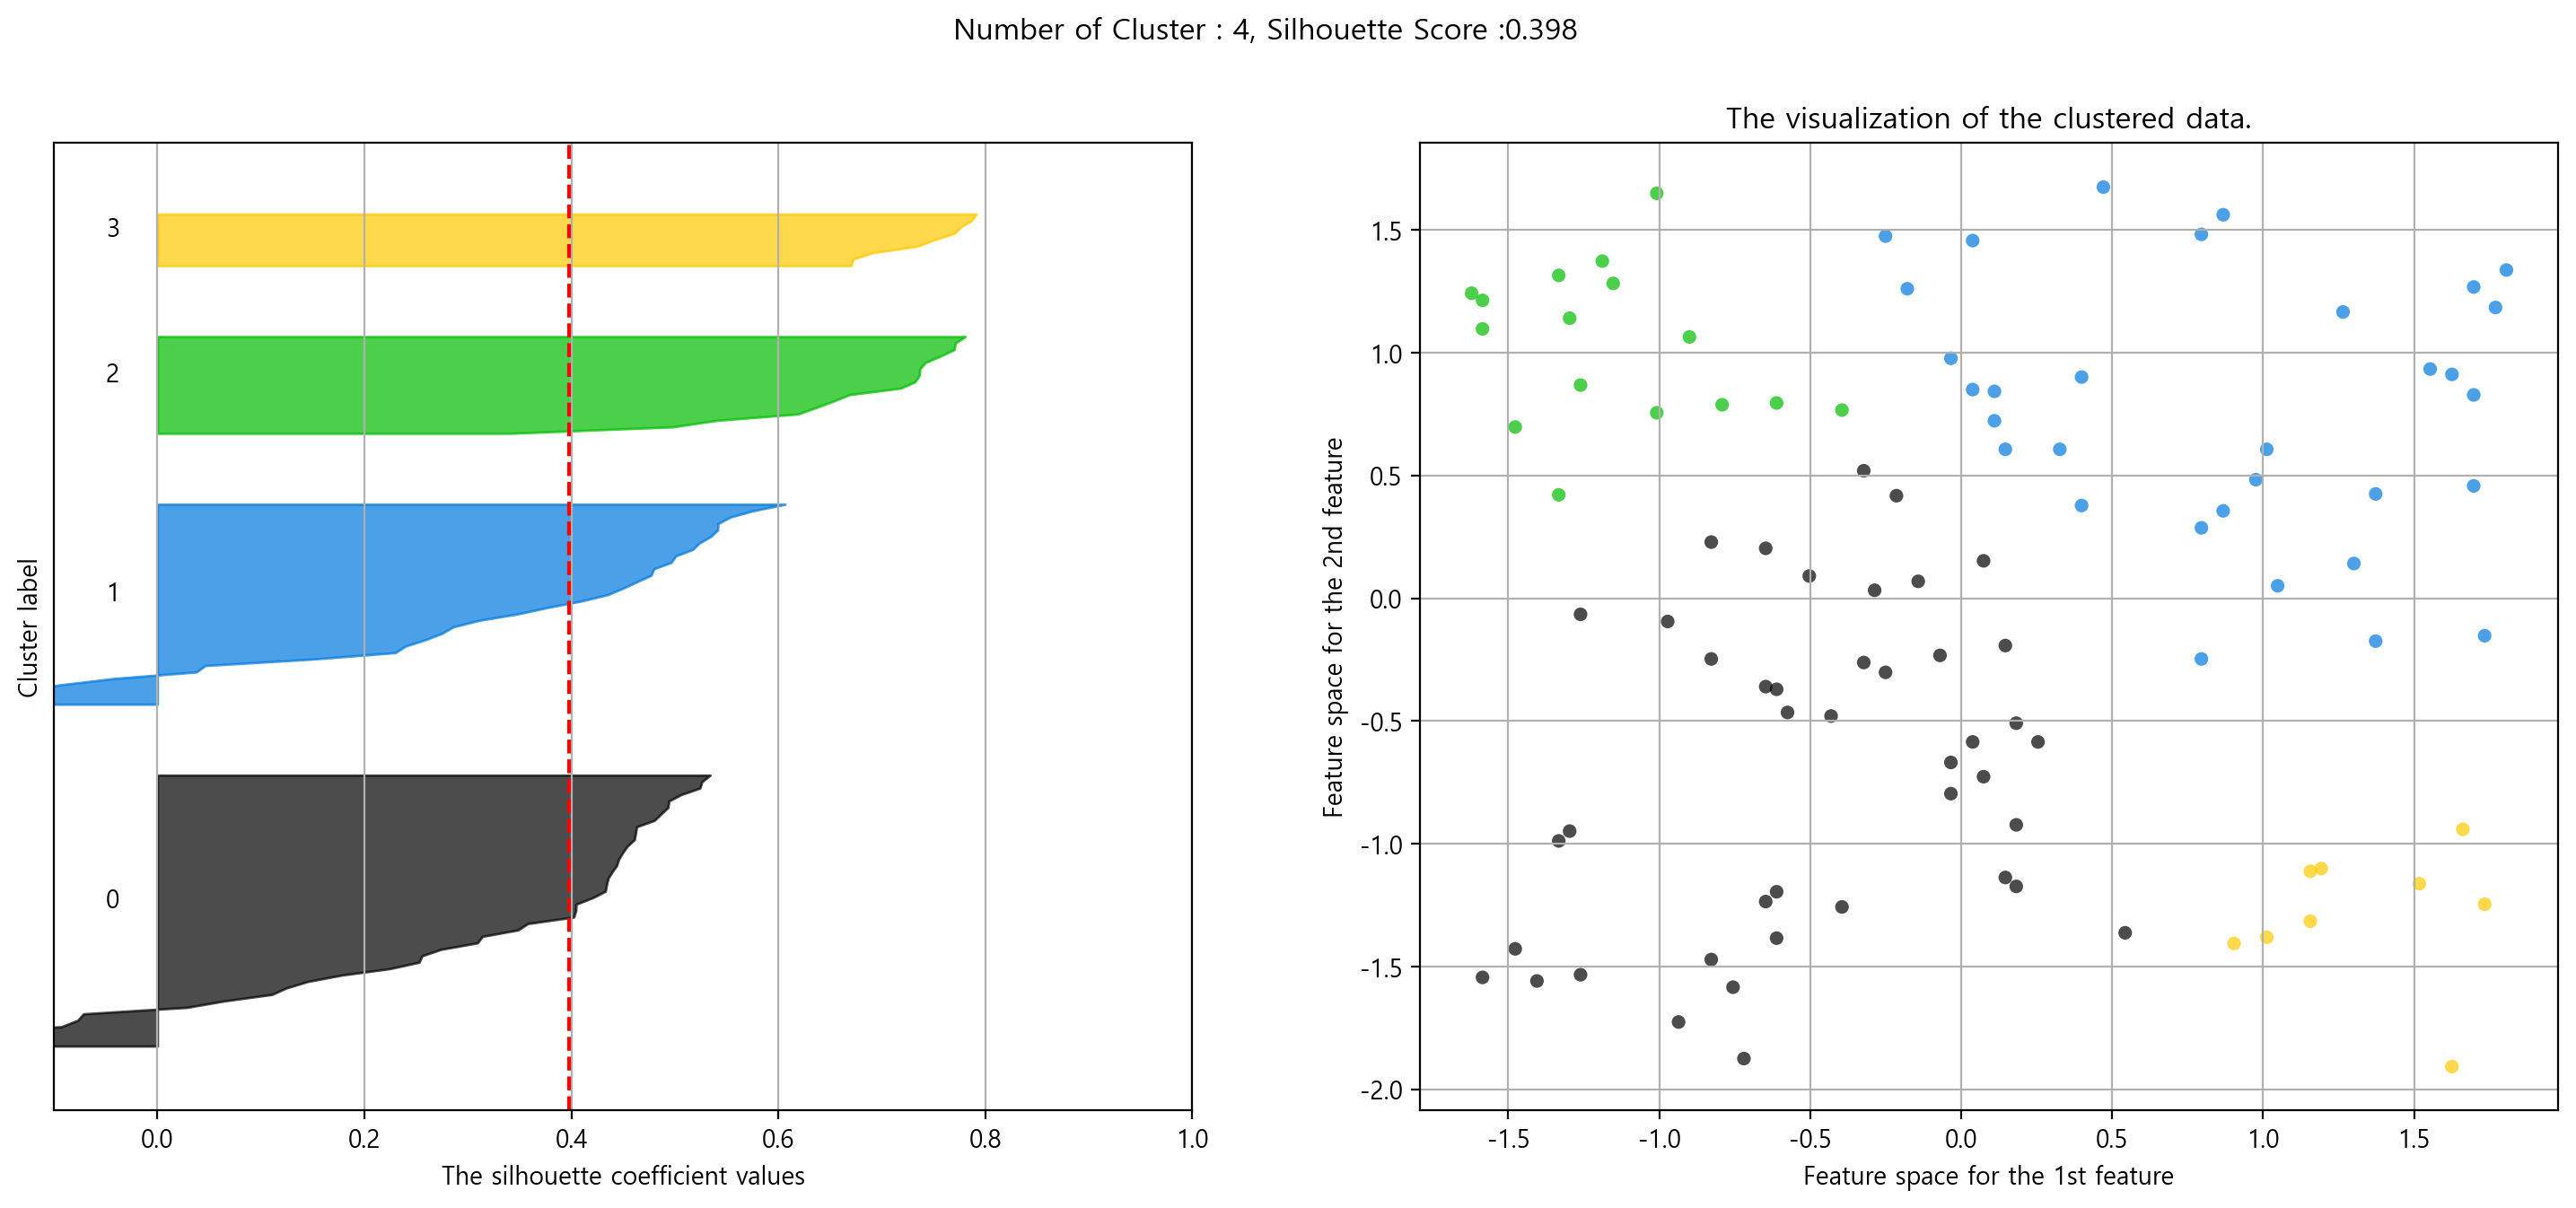

In [27]:
visualize_silhouette(estimator=estimator, X_features=df)

> 실루엣 점수가 그리 높지는 않다. 실루엣 점수는 모양이 복잡할때는 잘 들어맞지가 않기 때문에 실제로는 군집 결과를 시각화 한 후 분석가의 주관에 의한 판단이 필요하다.